## 目录
### 1、处理和整合矢量数据和栅格数据
### 2、分区统计（zonal stastics）
##### (1) 分区求均值
##### （2）双线性重采样处理缺失值
### 3、如何基于地理点，从栅格数据中提值
## 

## 使用矢量数据 + 栅格数据

本章使用美国气候数据


In [3]:
library(tidyverse)
library(sf)
library(terra)

Warning message:
"程辑包'tidyverse'是用R版本4.2.3 来建造的"
Warning message:
"程辑包'ggplot2'是用R版本4.2.3 来建造的"
Warning message:
"程辑包'tibble'是用R版本4.2.3 来建造的"
Warning message:
"程辑包'tidyr'是用R版本4.2.3 来建造的"
Warning message:
"程辑包'readr'是用R版本4.2.3 来建造的"
Warning message:
"程辑包'purrr'是用R版本4.2.3 来建造的"
Warning message:
"程辑包'dplyr'是用R版本4.2.3 来建造的"
Warning message:
"程辑包'stringr'是用R版本4.2.3 来建造的"
Warning message:
"程辑包'forcats'是用R版本4.2.3 来建造的"
Warning message:
"程辑包'lubridate'是用R版本4.2.3 来建造的"
-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<ht

前往脚本所在目录

In [4]:
dir <- getwd()
setwd(dir)

读取美国边界数据

In [5]:
county <- st_read("Chapter9/cb_2018_us_county_20m.shp")

Reading layer `cb_2018_us_county_20m' from data source 
  `C:\Users\77387\Desktop\Data_analysis_courses\RandSpecialAnalysis\Chapter9\cb_2018_us_county_20m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 3220 features and 9 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -179.1743 ymin: 17.91377 xmax: 179.7739 ymax: 71.35256
Geodetic CRS:  NAD83


In [6]:
class(county)
glimpse(county)

[1] "sf"         "data.frame"

Rows: 3,220
Columns: 10
$ STATEFP  <chr> "37", "37", "39", "42", "48", "48", "45", "01", "54", "46", "~
$ COUNTYFP <chr> "017", "167", "153", "113", "459", "049", "021", "043", "023"~
$ COUNTYNS <chr> "01026336", "01025844", "01074088", "01213687", "01384015", "~
$ AFFGEOID <chr> "0500000US37017", "0500000US37167", "0500000US39153", "050000~
$ GEOID    <chr> "37017", "37167", "39153", "42113", "48459", "48049", "45021"~
$ NAME     <chr> "Bladen", "Stanly", "Summit", "Sullivan", "Upshur", "Brown", ~
$ LSAD     <chr> "06", "06", "06", "06", "06", "06", "06", "06", "06", "06", "~
$ ALAND    <dbl> 2265887723, 1023370459, 1069181981, 1165338428, 1509910100, 2~
$ AWATER   <dbl> 33010866, 25242751, 18958267, 6617028, 24878888, 32375524, 11~
$ geometry <MULTIPOLYGON [arc_degree]> MULTIPOLYGON (((-78.902 34...., MULTIPO~


STATEFP 和 GEOID 原本是字符形式，字符转数值

只取了49个北美主体大陆的州

In [7]:
county <- county %>%
  mutate(state = as.numeric(STATEFP),
         fips = as.numeric(GEOID)) %>%
  filter(state != 2, state != 15, state < 60) 

读取数据的 crs

In [8]:
writeLines(st_crs(county)$WktPretty)

GEOGCS["NAD83",
    DATUM["North_American_Datum_1983",
        SPHEROID["GRS 1980",6378137,298.257222101]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4269"]]


读取美国 30年气候数据

In [9]:
prism_files <- c('PRISM_ppt_30yr_normal_4kmM4_annual_bil',
                  'PRISM_ppt_stable_4kmM3_201801_bil',
                  'PRISM_ppt_stable_4kmM3_201807_bil',
                  'PRISM_ppt_stable_4kmM3_201811_bil')

In [16]:
prism_paths <- file.path("./Chapter9", 
                         paste0(prism_files, ".bil"))
prism_paths

[1] "./Chapter9/PRISM_ppt_30yr_normal_4kmM4_annual_bil.bil"
[2] "./Chapter9/PRISM_ppt_stable_4kmM3_201801_bil.bil"     
[3] "./Chapter9/PRISM_ppt_stable_4kmM3_201807_bil.bil"     
[4] "./Chapter9/PRISM_ppt_stable_4kmM3_201811_bil.bil"

In [17]:
prism_p30 <- rast(prism_paths[1])
prism_prec_2018 <- rast(prism_paths[2:4])

## 分区统计（Zonal statistics）
分区统计：一种地理信息系统（GIS）技术，用于分析在特定区域内的地理数据，如土地覆盖、气候和人口分布等。

做 zonal statistic，需要首先把矢量的 polygon 数据转化为栅格数据，每个栅格单元用相应县的5位FIPS代码进行编码

In [18]:
cnty_ras <- rasterize(vect(county), 
                      prism_p30, 
                      field = "fips")
summary(cnty_ras)

Warning message:
"[summary] used a sample"


      fips      
 Min.   : 1001  
 1st Qu.:18177  
 Median :31091  
 Mean   :30738  
 3rd Qu.:46019  
 Max.   :56045  
 NA's   :45857  

In [19]:
cnty_p30 <- zonal(prism_p30, #多层栅格数据
                  cnty_ras, # 哪几个zones要做计算
                  fun = "mean", #求均值
                  na.rm = TRUE)
summary(cnty_p30)

      fips       PRISM_ppt_30yr_normal_4kmM4_annual_bil
 Min.   : 1001   Min.   :  79.69                       
 1st Qu.:19041   1st Qu.: 761.91                       
 Median :29205   Median :1091.00                       
 Mean   :30625   Mean   :1022.57                       
 3rd Qu.:45087   3rd Qu.:1274.34                       
 Max.   :56045   Max.   :3044.25                       

In [20]:
cnty_p30 <- rename(cnty_p30, 
                   precip = 2)

## 区域大小和栅格大小

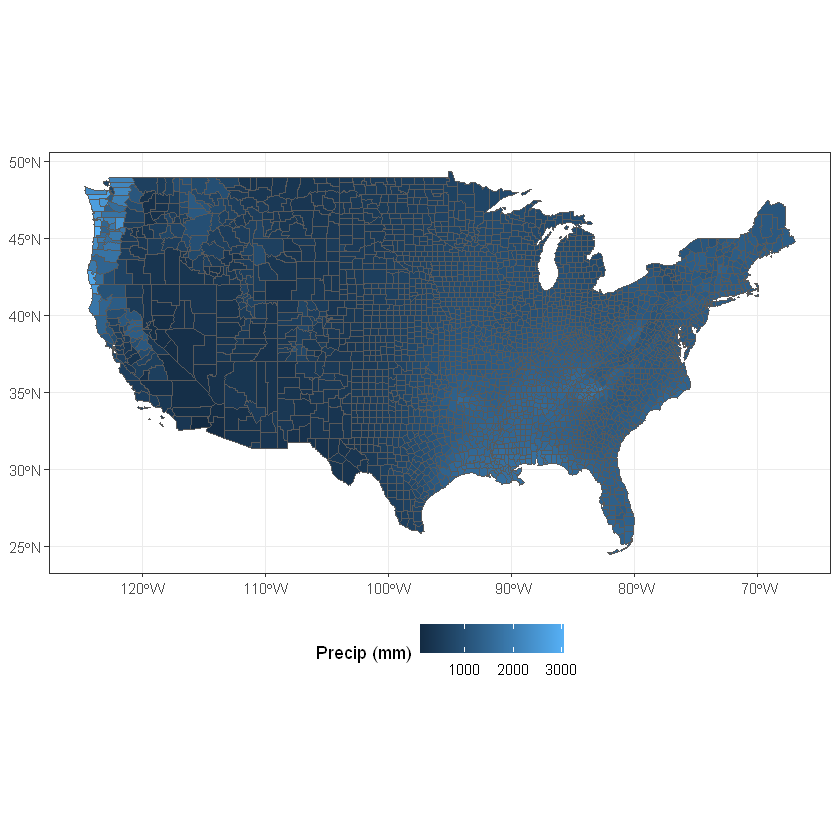

In [21]:
cnty_join1 <- left_join(county, 
                        cnty_p30, 
                        by = "fips")

ggplot(data = cnty_join1) +
  geom_sf(aes(fill = precip), size = 0.1) +
  scale_fill_continuous(name = "Precip (mm)") +
  theme_bw() +
  theme(legend.position = "bottom")

调整一下颜色

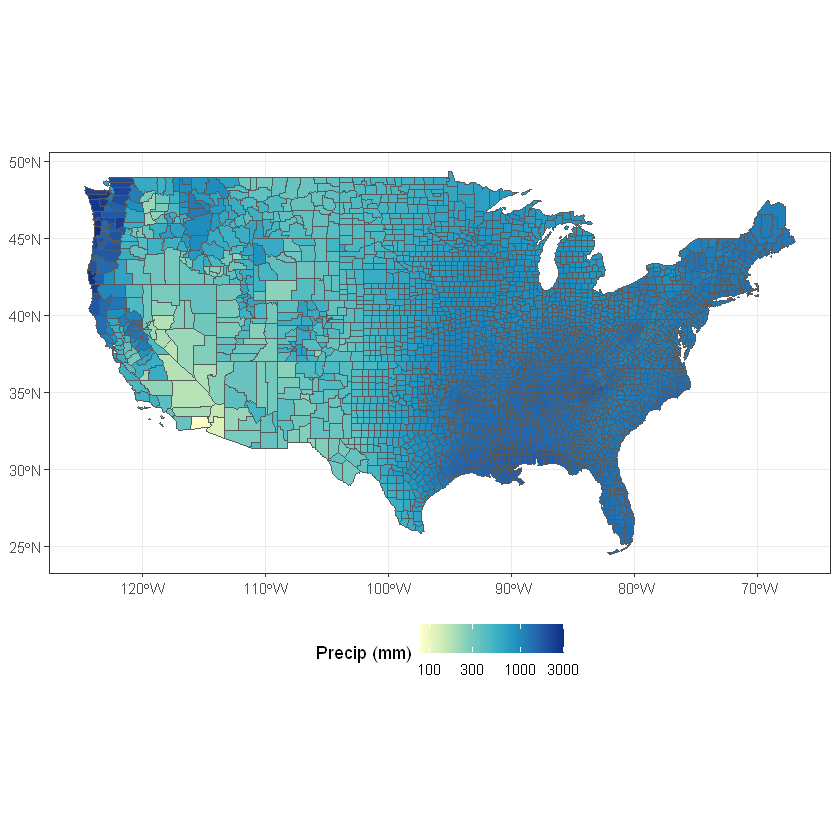

In [22]:
ggplot(data = cnty_join1) +
  geom_sf(aes(fill = precip), size = 0.1) +
  scale_fill_distiller(name = "Precip (mm)", 
                       palette = "YlGnBu", 
                       direction = 1,
                       trans = "log", 
                       breaks = c(100, 300, 1000, 3000)) +
  theme_bw() +
  theme(legend.position = "bottom")

判断一下有哪些州是不共有的

In [23]:
setdiff(county$fips, cnty_p30$fips) # FIPS 为51的都是弗吉尼亚州的

[1] 51580 51685 51610 51570 51683 51600 51678

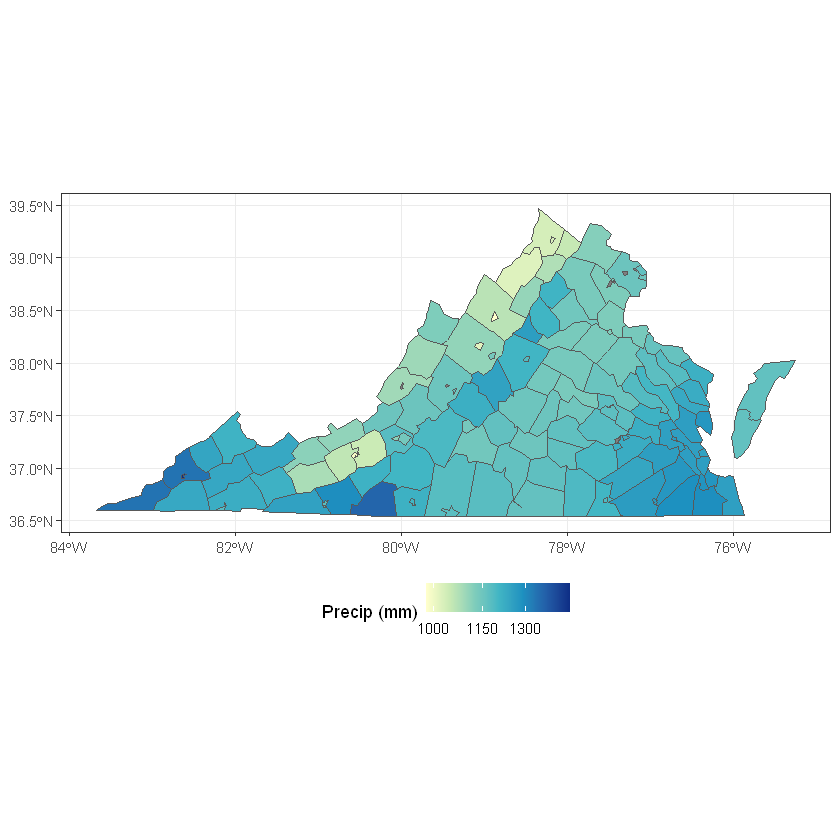

In [25]:
va_join1 <- filter(cnty_join1, 
                   STATEFP == "51") # 取出51的

# 看一下51的缺了哪些地区
ggplot(data = va_join1) +
  geom_sf(aes(fill = precip), size = 0.1) +
  scale_fill_distiller(name = "Precip (mm)", 
                       palette = "YlGnBu", 
                       direction = 1,
                       trans = "log", 
                       breaks = c(1000, 1150, 1300)) +
  theme_bw() +
  theme(legend.position = "bottom")

再放大一点

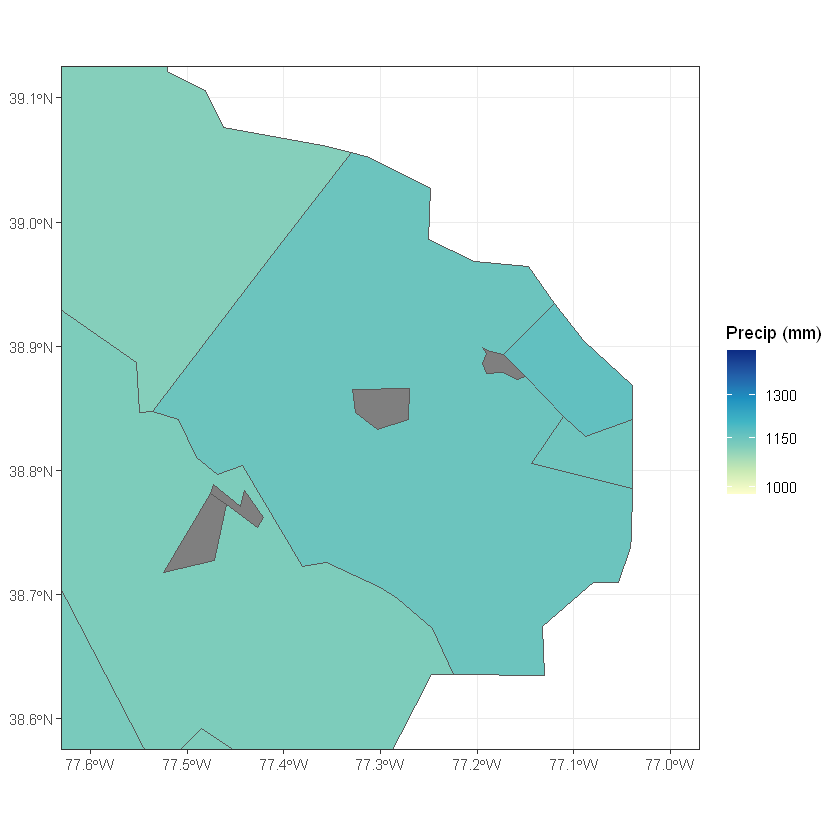

In [26]:
ggplot(data = va_join1) +
  geom_sf(aes(fill = precip), size = 0.25) +
  coord_sf(xlim = c(-77.6, -77.0), 
           ylim = c(38.6, 39.1)) +
  scale_fill_distiller(name = "Precip (mm)", 
                       palette = "YlGnBu", 
                       direction = 1,
                       trans = "log", 
                       breaks = c(1000, 1150, 1300)) +
  theme_bw()

处理这种缺失值的方法：

采用双线性重采样（Bilinear resampling），

在4 km栅格单元的中心点之间进行线性插值，以估计1 km分辨率的值。
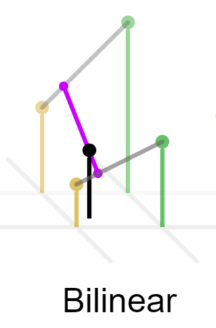

In [27]:
prism_p30_1km <- disagg(prism_p30, 
                        fact = 4, 
                        method = "bilinear")
cnty_ras_1km <- rasterize(vect(county), 
                          prism_p30_1km, 
                          field = "fips")
cnty_p30_1km <- zonal(prism_p30_1km, 
                      cnty_ras_1km, 
                      fun = "mean", 
                      na.rm=T)
summary(cnty_p30_1km)

      fips       PRISM_ppt_30yr_normal_4kmM4_annual_bil
 Min.   : 1001   Min.   :  79.2                        
 1st Qu.:19045   1st Qu.: 763.3                        
 Median :29212   Median :1091.8                        
 Mean   :30672   Mean   :1022.6                        
 3rd Qu.:46008   3rd Qu.:1273.7                        
 Max.   :56045   Max.   :3019.2                        

In [28]:
cnty_p30_1km <- rename(cnty_p30_1km, 
                       precip = 2)

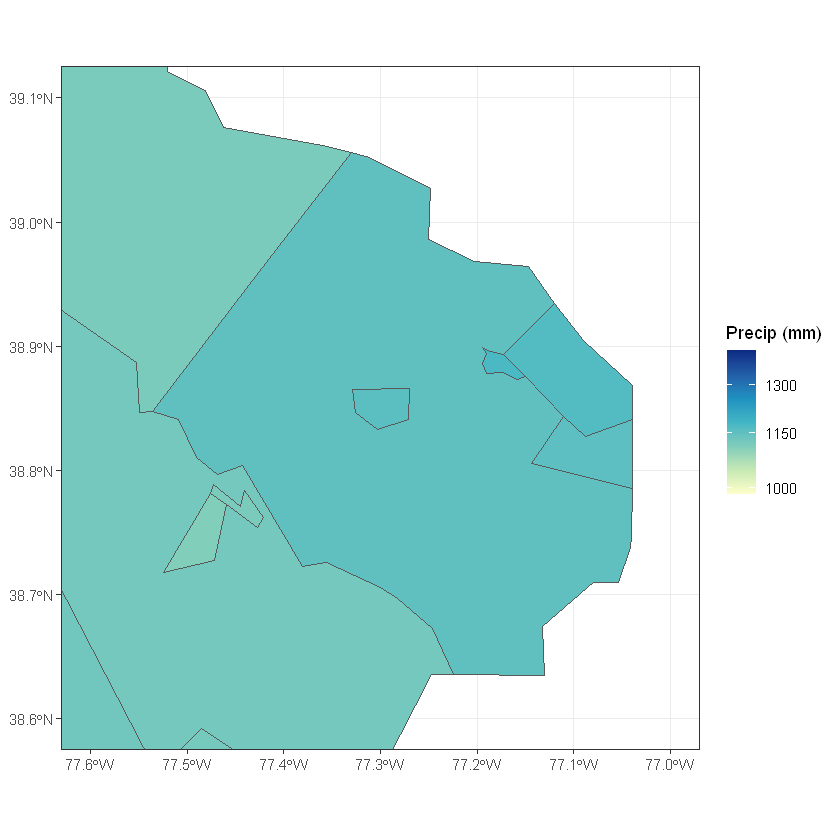

In [29]:
cnty_join2 <- left_join(county, 
                        cnty_p30_1km, 
                        by = "fips")
va_join2 <- filter(cnty_join2, STATEFP == "51")

ggplot(data = va_join2) +
  geom_sf(aes(fill = precip), size = 0.25) +
  scale_fill_distiller(name = "Precip (mm)", 
                       palette = "YlGnBu", 
                       direction = 1,
                       trans = "log", 
                       breaks = c(1000, 1150, 1300)) +
  coord_sf(xlim = c(-77.6, -77.0), 
           ylim = c(38.6, 39.1)) +
  theme_bw()

## Extracting Raster Values with Point Data

mesodata_small.csv:Mesonet 气象站记录的每年1、4、11月气候数据

geoinfo.csv：各地区地理坐标

问：Mesonet 气象站的数据（矢量数据） 和 PRISM的数据（栅格数据）一致性如何？ 

In [2]:
mesosm <- read.csv("Chapter9/mesodata_small.csv")
geo_coords <- read.csv("Chapter9/geoinfo.csv")

geo_coords 转化成 sf 数据

In [31]:
geo_coords <- st_as_sf(geo_coords, 
                       coords = c("lon", "lat"))

mystations <- unique(mesosm$STID) #取出 mesosm 的城市 ID
station_pts <- geo_coords %>%
  filter(stid %in% mystations)  # 过滤出 城市ID 的数据

extract() 用来提取出对应的栅格数据点

In [34]:
names(prism_prec_2018) <- c("Jan","Jul","Nov")
prism_samp <- extract(prism_prec_2018, 
                      vect(station_pts), 
                      factors = T, 
                      df = T)

 拼接，取出2018的记录，整理数据，准备分析和画图

In [36]:
compare_prec <- prism_samp %>% 
  bind_cols(station_pts) %>%
  pivot_longer(Jan:Nov, 
               names_to = "mnth_name", 
               values_to = "PPrec") %>%
  mutate(month = match(mnth_name, month.abb),
         PPrec_in = PPrec * 0.0393701) %>%
  inner_join(mesosm, by = c("stid" = "STID", "month" = "MONTH")) %>%
  filter(YEAR == 2018) %>%
  select(stid, month, RAIN, PPrec_in)

Mesonet气象站数据在x轴上与网格化PRISM数据在y轴上的关系

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


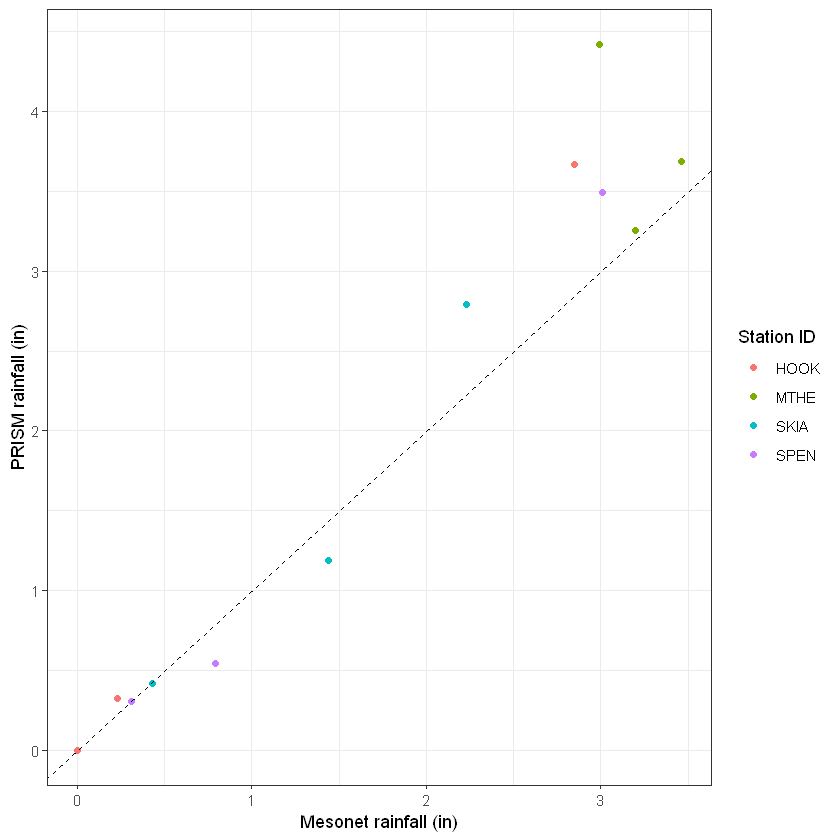

In [37]:
ggplot(data = compare_prec) +
  geom_point(aes(x = RAIN, 
                 y = PPrec_in, 
                 color = stid)) +
  scale_color_discrete(name = "Station ID") +
  geom_abline(slope = 1, 
              intercept = 0,
              size = 0.25,
              linetype = "dashed") +
  xlab("Mesonet rainfall (in)") +
  ylab("PRISM rainfall (in)") +
  theme_bw()

In [38]:
rain_lm <- lm(PPrec_in ~ RAIN, data = compare_prec)
summary(rain_lm)


Call:
lm(formula = PPrec_in ~ RAIN, data = compare_prec)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51722 -0.32992  0.02155  0.16507  0.90223 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.10997    0.20183  -0.545    0.598    
RAIN         1.21354    0.09315  13.028 1.34e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4145 on 10 degrees of freedom
Multiple R-squared:  0.9444,	Adjusted R-squared:  0.9388 
F-statistic: 169.7 on 1 and 10 DF,  p-value: 1.344e-07


In [39]:
rain_sum <- compare_prec %>%
  summarize(RMSE = sqrt(mean((PPrec_in - RAIN)^2)),
            MAE = mean(abs(PPrec_in - RAIN)),
            ME = mean(PPrec_in - RAIN))